# Seasonal evolution of atmospheric CO2 over the Southern Ocean

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import obs_aircraft
import emergent_constraint as ec
import datasets

import figure_panels
import util

In [26]:
clobber = False 
clobber_deep = False
constraint_type = 'ocean_constraint'
campaign_info = obs_aircraft.get_campaign_info(verbose=False)
model_input_lists = ec.get_model_tracer_lists(constraint_type)
model_input_lists

{'model_tracer_list': [('CT2017', 'CO2_OCN'),
  ('CT2019B', 'CO2_OCN'),
  ('CTE2018', 'CO2_OCN'),
  ('CTE2020', 'CO2_OCN'),
  ('MIROC', 'CO2_OCN'),
  ('CAMSv20r1', 'CO2_OCN'),
  ('s99oc_v2020', 'CO2_OCN'),
  ('s99oc_ADJocI40S_v2020', 'CO2_OCN'),
  ('s99oc_SOCCOM_v2020', 'CO2_OCN'),
  ('TM5-Flux-m0f', 'CO2_OCN'),
  ('TM5-Flux-mmf', 'CO2_OCN'),
  ('TM5-Flux-mrf', 'CO2_OCN'),
  ('TM5-Flux-mwf', 'CO2_OCN')],
 'model_tracer_ext_list': [('CT2017', 'CO2_LND+CO2_FFF'),
  ('CT2019B', 'CO2_LND+CO2_FFF'),
  ('CTE2018', 'CO2_LND+CO2_FFF'),
  ('CTE2020', 'CO2_LND+CO2_FFF'),
  ('CAMSv20r1', 'CO2_LND+CO2_FFF'),
  ('s99oc_v2020', 'CO2_LND+CO2_FFF'),
  ('s99oc_ADJocI40S_v2020', 'CO2_LND+CO2_FFF'),
  ('s99oc_SOCCOM_v2020', 'CO2_LND+CO2_FFF')],
 'model_list_sfco2_lnd': []}

In [30]:
air_parms = ec.get_parameters('default')
obj_srf = ec.whole_enchilada_srf(**model_input_lists)
obj_air = ec.whole_enchilada(clobber=clobber_deep, **model_input_lists)

ac = obj_air.get_ac(**air_parms, clobber=clobber)
sc = obj_srf.get_sc(clobber=clobber)

In [31]:
ac.vg_ext

co2  gradient_mean  gradient_std
model        tracer  campaign                                       
TM5-Flux-m0f CO2_OCN HIPPO-1  -0.400970      -0.400970           NaN
                     HIPPO-2  -0.073724      -0.073724           NaN
                     HIPPO-3  -0.399585      -0.399585           NaN
                     HIPPO-5  -0.056967      -0.056967           NaN
                     ORCAS-J  -0.506230      -0.506230           NaN
...                                 ...            ...           ...
CTE2018      CO2_FFF ORCAS-F  -0.265750      -0.265750           NaN
                     ATOM-1   -0.202980      -0.202980           NaN
                     ATOM-2   -0.154555      -0.154555           NaN
                     ATOM-3   -0.216050      -0.216050           NaN
                     ATOM-4         NaN            NaN           NaN

[450 rows x 3 columns]

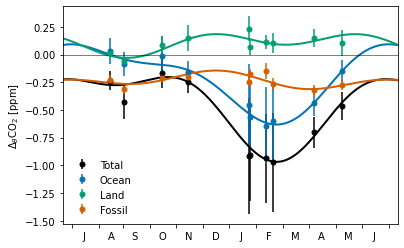

In [32]:
def vg_seasonal_cycle_model_flavors(ac, ax):

    df = ac.vg_ext
    co2_components = ['CO2', 'CO2_OCN', 'CO2_LND', 'CO2_FFF',]# 'CO2_LND+CO2_FFF']
   
    doy = []
    for c in campaign_info.keys():
        doy.append(util.day_of_year(np.array([campaign_info[c]['time']]))[0])

    data = {k: [] for k in co2_components}
    error = {k: [] for k in co2_components}
    for c in campaign_info.keys():    
        for tracer in co2_components:
            data[tracer].append(
                df.xs((c, tracer), level=('campaign', 'tracer')).gradient_mean.median()
            )
            error[tracer].append(
                df.xs((c, tracer), level=('campaign', 'tracer')).gradient_mean.std(ddof=1)
            )

    xhat = np.linspace(-30, 365+30, 365)

    for tracer in co2_components:
        x, y = util.antyear_daily(np.array(doy), np.array(data[tracer]))
        _, yerr = util.antyear_daily(np.array(doy), np.array(error[tracer]))
        ax.errorbar(x, y, yerr=yerr, 
                    linestyle='none', 
                    color=figure_panels.co2_colors[tracer], 
                    marker='.', 
                    markersize=10,
                    label=figure_panels.co2_names[tracer], 
                   )
        p, pcov = ec.curve_fit(ec.harmonic, xdata=x/365.25, ydata=y, sigma=yerr, absolute_sigma=True,)
        yhat = ec.harmonic(xhat/365.25, *p)
        ax.plot(xhat, yhat, color=figure_panels.co2_colors[tracer], lw=2)
        if tracer == 'CO2':
            yhat_out = yhat
            
    ax.axhline(0., lw=0.5, c='k')
    ax.legend(loc=(1.02, 0), ncol=1, fontsize=8);  
    ax.set_xlim((-10, 375))
    ax.set_xticks(figure_panels.bomday)
    ax.set_xticklabels([f'        {m}' for m in figure_panels.monlabs_ant]+['']);
    ax.legend(frameon=False)
    ax.set_ylabel('$\Delta_{ \\theta}$CO$_2$ [ppm]')
    return yhat_out

fig, axs = util.canvas(1, 1)
co2_air = vg_seasonal_cycle_model_flavors(ac, axs[0, 0]) 

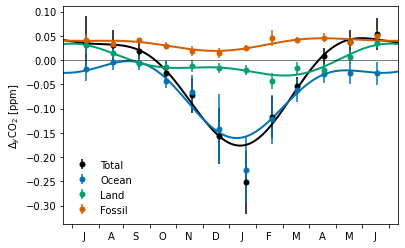

In [34]:
def hg_seasonal_cycle_model_flavors(sc, ax, period='1999-2020'):

    df = sc.df_gradients_mon
    co2_components = ['CO2', 'CO2_OCN', 'CO2_LND', 'CO2_FFF',]# 'CO2_LND+CO2_FFF']
   
    doy = util.doy_midmonth()

    data = {k: [] for k in co2_components}
    error = {k: [] for k in co2_components}
    for month in range(1, 13):
        for tracer in co2_components:
            gradient = df.xs((period, month, tracer), level=('period', 'month', 'tracer')).gradient
            data[tracer].append(gradient.median())
            error[tracer].append(gradient.std(ddof=1))
    
    xhat = np.linspace(-30, 365+30, 365)

    for tracer in co2_components:
        x, y = util.antyear_daily(np.array(doy), np.array(data[tracer]))
        _, yerr = util.antyear_daily(np.array(doy), np.array(error[tracer]))
        ax.errorbar(x, y, yerr=yerr, 
                    linestyle='none', 
                    color=figure_panels.co2_colors[tracer], 
                    marker='.', 
                    markersize=10,
                    label=figure_panels.co2_names[tracer], 
                   )
        p, pcov = ec.curve_fit(ec.harmonic, xdata=x/365.25, ydata=y, sigma=yerr, absolute_sigma=True,)
        yhat = ec.harmonic(xhat/365.25, *p)            
        ax.plot(xhat, yhat, color=figure_panels.co2_colors[tracer], lw=2)
        if tracer == 'CO2':
            yhat_out = yhat

    ax.axhline(0., lw=0.5, c='k')
    ax.legend(loc=(1.02, 0), ncol=1, fontsize=8);  
    ax.set_xlim((-10, 375))
    ax.set_xticks(figure_panels.bomday)
    ax.set_xticklabels([f'        {m}' for m in figure_panels.monlabs_ant]+['']);
    ax.legend(frameon=False)
    ax.set_ylabel('$\Delta_{ y}$CO$_2$ [ppm]')
    return yhat_out 
fig, axs = util.canvas(1, 1)

co2_srf = hg_seasonal_cycle_model_flavors(sc, axs[0, 0]) 

In [35]:
(co2_air.max() - co2_air.min())/(co2_srf.max() - co2_srf.min())

3.452936031297747

In [36]:
data_a_clm = datasets.obs_surface_climatology('co2')
data_a_clm

<xarray.Dataset>
Dimensions:  (stncode: 8, month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * stncode  (stncode) object 'CRZ' 'MQA' 'DRP' 'PSA' 'SYO' 'CYA' 'MAA' 'HBA'
Data variables:
    lat      (stncode, month) float64 -46.43 -46.43 -46.43 ... -75.61 -75.61
    CO2      (stncode, month) float64 -0.5135 -0.3997 ... 0.002222 -0.1295
    CO2_std  (month) float64 0.09334 0.165 0.1028 ... 0.09245 0.07162 0.1015

In [37]:
ds_obs = datasets.aircraft_profiles_seasonal()
ds_obs

<xarray.Dataset>
Dimensions:      (season: 4, theta: 11)
Coordinates:
  * season       (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
  * theta        (theta) float64 270.0 275.0 280.0 285.0 ... 310.0 315.0 320.0
Data variables:
    co2_med      (season, theta) float64 -1.647 -1.448 -1.168 ... 0.4944 0.3504
    co2_med_std  (season, theta) float64 0.306 0.3088 0.3317 ... 0.397 0.6203

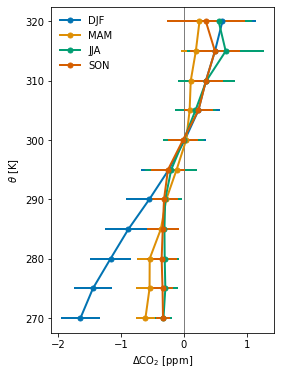

In [38]:
def plot_seasonal_profiles(ds_obs, ax):
    theta = ds_obs.theta
    seasons = ds_obs.season.values
    field = 'co2'
    for n, season in enumerate(seasons):
        dsi = ds_obs.sel(season=season)
        x, xerr = dsi[f'{field}_med'], dsi[f'{field}_med_std']
        ax.errorbar(x, theta, 
                    xerr=xerr, 
                    marker='.', 
                    label=season,
                    lw=2, 
                    c=figure_panels.palette_colors[n],
                    markersize=10, 
                    zorder=100,
                   )
    ax.axvline(0., lw=0.5, c='k')    
    ax.legend(frameon=False)    
    ax.set_ylabel('$\\theta$ [K]')
    ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
        
    xlm = ax.get_xlim()

fig, axs = util.canvas(1, 1, figsize=(4, 6))
plot_seasonal_profiles(ds_obs, axs[0, 0])

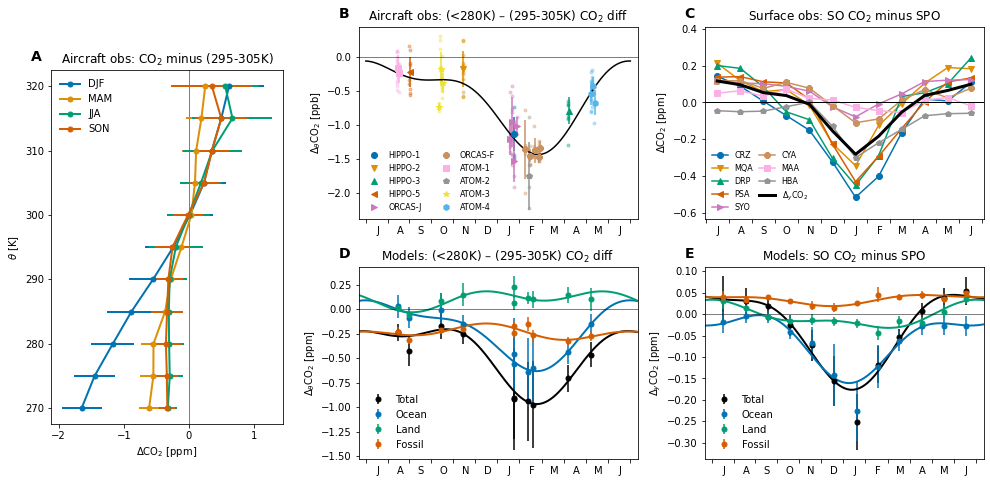

In [39]:
fig = plt.figure(figsize=(14, 6)) #dpi=300)

# set up plot grid
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    left=0.38, right=1,
    bottom=0., top=1,
    hspace=0.25, wspace=0.24,
)

nrow = 2
ncol = 2
axs = np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):
    axs[i, j] = plt.subplot(gs[i, j])

ax_p = fig.add_axes([0.075, 0.08, 0.23, 0.82])
plot_seasonal_profiles(ds_obs, ax_p)
tbin = ac.theta_bins[0]
ax_p.set_title(f'Aircraft obs: CO$_2$ minus ({tbin[0]:0.0f}-{tbin[1]:0.0f}K)')
figure_panels.obs_theta_gradient(ac.flight_gradients, axs[0, 0], ac.theta_bins);
ylm = axs[0, 0].get_ylim()

theta_str = figure_panels.theta_bin_def(ac.theta_bins)
vg_seasonal_cycle_model_flavors(ac, axs[1, 0])
axs[1, 0].set_title(f'Models: {theta_str} CO$_2$ diff')

figure_panels.obs_srf_seasonal(axs[0, 1], data_a_clm)

hg_seasonal_cycle_model_flavors(sc, axs[1, 1])
axs[1, 1].set_title(f'Models: SO CO$_2$ minus SPO')

util.label_plots(fig, [ax_p]+[ax for ax in axs.ravel()], xoff=-0.02)

util.savefig(f'Fig-2-metrics-seasonal-cycle.pdf')